In [2]:
from networks.mpnet import MPNet
from networks.costnet import CostNet

import torch
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sst_envs.utils import load_data, visualize_point

In [3]:
setup = "subset"
# setup = "default_norm"
# setup = "default_norm_aug"
# setup = "norm_nodiff_noaug_20step2e-2"
# setup = "norm_nodiff_noaug_5step2e-2"
# setup = "norm_nodiff_noaug_20step2e-3"
mpnet = MPNet(ae_input_size=32, ae_output_size=1024, in_channels=1, state_size=4)


# setup = "default_norm_noaug_control"
# setup = "norm_nodiff_noaug_20step2e-2_control"

# mpnet = MPNet(ae_input_size=32, ae_output_size=128, in_channels=1, state_size=4, control_size=2)


model = "acrobot_obs"
env = 1
traj_id = 233
goal_radius = 2


mpnet.load_state_dict(torch.load('output/acrobot_obs/{}/ep1000'.format(setup)))
setup = "default_norm"

costnet = CostNet(ae_input_size=32, ae_output_size=1024, in_channels=1, state_size=4, encoder=mpnet.encoder)
costnet.load_state_dict(torch.load('output/acrobot_obs/{}/costnet/ep15'.format(setup)))
costnet.eval()

# mpnet.eval()
mpnet.train()

def evaluate(start_th, goal_th, env_vox, net):
    start_goal = torch.cat((start_th.float(), goal_th.float()), dim=1)
    with torch.no_grad():
        sample = net(start_goal, env_vox)         
    return sample.clone()
def visualize(path, start, goal, ax, color='skyblue'):
    path = np.array(path)
    ax.scatter(start[0], start[1], color='orange')
    ax.scatter(goal[0], goal[1], color='red')
    ax.plot(path[:, 0], path[:, 1], color=color)
    ax.scatter(path[:, 0], path[:, 1], color='blue', s=3)
    ax.scatter(path[-1, 0], path[-1, 1], color='orange')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

def distance(point1, point2):
    LENGTH = 20.
    x = np.cos(point1[0] - np.pi / 2)+np.cos(point1[0] + point1[1] - np.pi / 2)
    y = np.sin(point1[0] - np.pi / 2)+np.sin(point1[0] + point1[1] - np.pi / 2)
    x2 = np.cos(point2[0] - np.pi / 2)+np.cos(point2[0] + point2[1] - np.pi / 2)
    y2 = np.sin(point2[0] - np.pi / 2)+np.sin(point2[0] + point2[1] - np.pi / 2)
    return LENGTH*np.sqrt((x-x2)**2+(y-y2)**2)
env_vox_all = torch.from_numpy(np.load('sst_envs/{}_env_vox.npy'.format(model))).float()
env_vox = env_vox_all[env].float().unsqueeze(0)
ref_path_dict = load_data(model, env, traj_id)
ref_path = ref_path_dict['path']
ref_sg = ref_path_dict['start_goal']

RuntimeError: Error(s) in loading state_dict for CostNet:
	Missing key(s) in state_dict: "encoder.encoder.3.bias", "encoder.encoder.4.weight", "mlp.fc.9.bias". 
	Unexpected key(s) in state_dict: "encoder.encoder.2.weight", "encoder.encoder.2.bias", "mlp.fc.10.weight", "mlp.fc.10.bias", "mlp.fc.11.weight", "mlp.fc.12.weight", "mlp.fc.12.bias", "mlp.fc.13.weight", "mlp.fc.14.weight", "mlp.fc.14.bias", "mlp.fc.15.weight", "mlp.fc.16.weight", "mlp.fc.16.bias", "mlp.fc.8.weight", "mlp.fc.8.bias". 
	While copying the parameter named "encoder.encoder.0.weight", whose dimensions in the model are torch.Size([128, 1, 5, 5]) and whose dimensions in the checkpoint are torch.Size([64, 1, 5, 5]).
	While copying the parameter named "encoder.encoder.0.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([64]).
	While copying the parameter named "encoder.head.0.weight", whose dimensions in the model are torch.Size([256, 256]) and whose dimensions in the checkpoint are torch.Size([256, 1152]).
	While copying the parameter named "encoder.head.2.weight", whose dimensions in the model are torch.Size([1024, 256]) and whose dimensions in the checkpoint are torch.Size([64, 256]).
	While copying the parameter named "encoder.head.2.bias", whose dimensions in the model are torch.Size([1024]) and whose dimensions in the checkpoint are torch.Size([64]).
	While copying the parameter named "mlp.fc.0.weight", whose dimensions in the model are torch.Size([2048, 1032]) and whose dimensions in the checkpoint are torch.Size([2048, 72]).
	While copying the parameter named "mlp.fc.3.weight", whose dimensions in the model are torch.Size([512, 2048]) and whose dimensions in the checkpoint are torch.Size([1024, 2048]).
	While copying the parameter named "mlp.fc.3.bias", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "mlp.fc.6.weight", whose dimensions in the model are torch.Size([256, 512]) and whose dimensions in the checkpoint are torch.Size([512, 1024]).
	While copying the parameter named "mlp.fc.6.bias", whose dimensions in the model are torch.Size([256]) and whose dimensions in the checkpoint are torch.Size([512]).

In [1]:
print(ref_path_dict['cost'].sum())

NameError: name 'ref_path_dict' is not defined

In [ ]:
# %matplotlib notebook
# endeff = np.array(endeff)
# node1 = np.array(node1)
# x1, y1, x2, y2 = visualize_point(ref_path[-1])
# plt.plot(endeff[:,0], endeff[:,1], color='skyblue')
# plt.scatter(endeff[:,0], endeff[:,1], color='blue', s=1)

# for i in range(endeff.shape[0]):
#     plt.plot([0, node1[i,0]], [0, node1[i,1]], color='black')
#     plt.plot([node1[i,0], endeff[i,0]], [node1[i,1], endeff[i,1]], color='black')

# plt.scatter(endeff[0, 0], endeff[0, 1], color='green')
# plt.scatter(x2, y2, color='red')
# plt.xlim(-41, 40)
# plt.ylim(-41, 40)


In [12]:
node_id = 1
start = ref_path[node_id].copy()
gt = ref_path[node_id+1].copy()
# goal = ref_path[-1].copy()
goal = ref_sg[-1].copy()
start[:2] /= np.pi
start[2:] /= 6
goal[:2] /= np.pi
goal[2:] /= 6

num_sample = 500

start_th = torch.from_numpy(start).unsqueeze(0).float().repeat([num_sample,1])
goal_th = torch.from_numpy(goal).unsqueeze(0).float().repeat([num_sample,1])

def plan_cost(state_th, goal_th, mpnet, costnet):
    sample = evaluate(state_th, goal_th, env_vox.repeat([num_sample, 1, 1, 1]), mpnet)
    costs = evaluate(sample, goal_th, env_vox.repeat([num_sample, 1, 1, 1]), costnet)
    return sample, costs

def select_sample(sample, cost):
    cost_sorted, indices = torch.sort(cost.reshape(-1))
    idx = indices[0]
    new_sample = sample[idx].repeat([num_sample, 1])
    return new_sample,cost[idx]

samples, cost = plan_cost(start_th, goal_th, mpnet, costnet)
new_sample, min_cost = select_sample(samples, cost)
new_sample[0], min_cost

(tensor([-0.1239, -0.3447,  0.2112, -0.4193]), tensor([ 4.4861]))

In [13]:
start_th = torch.from_numpy(start).unsqueeze(0).float().repeat([num_sample,1])
goal_th = torch.from_numpy(goal).unsqueeze(0).float().repeat([num_sample,1])


endeff = [[0, -40]]
node1 = [[0, -20]]
path = []
path.append(start_th[0].numpy())
min_cost = np.inf

for i in range(20):
    samples, cost = plan_cost(start_th, goal_th, mpnet, costnet)
    new_sample, new_cost = select_sample(samples, cost)
    
    print(new_sample[0], new_cost)
#     if new_cost < min_cost:
    if True:
        min_cost = new_cost
        start_th = new_sample
        if start_th[0, 0] > 1:
            start_th[:, 0] -= 2
        if start_th[0, 0] < -1:
            start_th[:, 0] += 2

        if start_th[0, 1] > 1:
            start_th[:, 1] -= 2
        if start_th[0, 1] < -1:
            start_th[:, 1] += 2

        if start_th[0, 2] > 1:
            start_th[:, 2] = 1
        if start_th[0, 2] < -1:
            start_th[:, 2] = -1

        if start_th[0, 3] > 1:
            start_th[:, 3] = 1
        if start_th[0, 3] < -1:
            start_th[:, 3] = -1

        ex1, ey1, ex2, ey2 = visualize_point(start_th.clone()[0] * torch.tensor([np.pi, np.pi, 6, 6]))
        endeff.append([ex2, ey2])
        node1.append([ex1, ey1])
        path.append(start_th[0].numpy().copy())
    
        dis = distance(start_th[0] * torch.tensor([np.pi, np.pi, 6, 6]), goal_th[0] * torch.tensor([np.pi, np.pi, 6, 6]))
        print(i,dis)
    if dis < goal_radius or min_cost < 0.2:
        break

tensor([-0.0785, -0.5640,  0.4881, -0.6109]) tensor([ 3.3469])
0 tensor(43.5165)
tensor([ 0.4431,  0.4654,  0.4152, -0.3538]) tensor([ 1.8239])
1 tensor(33.4699)
tensor([ 0.4382,  0.3170, -0.1992,  0.1982]) tensor([ 2.1408])
2 tensor(43.0385)
tensor([ 0.3004,  0.5491, -0.4442,  0.4957]) tensor([ 2.5168])
3 tensor(38.2761)
tensor([ 0.0605,  0.8303, -0.7417,  0.4770]) tensor([ 1.8290])
4 tensor(33.7892)
tensor([-0.5749, -0.3562, -0.0504,  0.1237]) tensor([ 1.0477])
5 tensor(19.0730)
tensor([-0.3898, -0.5369,  0.7137, -0.6614]) tensor([ 0.8361])
6 tensor(24.3896)
tensor([ 0.4766,  0.6856,  0.8487, -0.7791]) tensor([ 0.4755])
7 tensor(20.2666)
tensor([ 0.6956,  0.3194,  0.2324, -0.3763]) tensor([ 0.6514])
8 tensor(20.8456)
tensor([ 0.7363,  0.3107, -0.0857,  0.0527]) tensor([ 0.7080])
9 tensor(17.6175)
tensor([ 0.7519,  0.1372, -0.0114, -0.0239]) tensor([ 0.6888])
10 tensor(26.4865)
tensor([ 0.7004,  0.2213, -0.1204,  0.0780]) tensor([ 0.9095])
11 tensor(26.4246)
tensor([ 0.6247,  0.0754, 

In [15]:
saved_path = np.array(path)[:, :4].copy()
saved_path[:, :2] *= np.pi
saved_path[:, 2:] *= 6
np.save('mpnet_path.npy', saved_path)

<IPython.core.display.Javascript object>


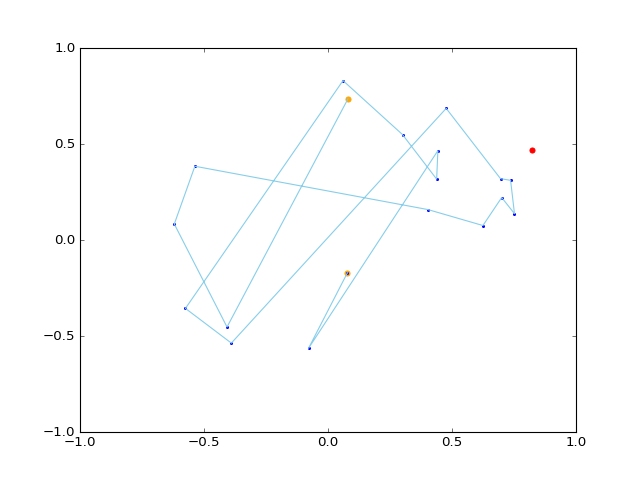

In [16]:
%matplotlib notebook
fig2, ax2 = plt.subplots()
visualize(path, start, goal, ax2)
# visualize(path_from_data, path_from_data[0], path_from_data[-1], ax2, color='green')

<IPython.core.display.Javascript object>


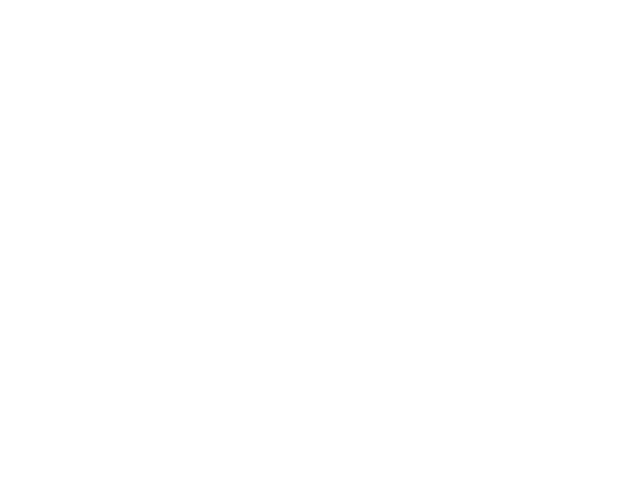

(-41, 40)

In [101]:
%matplotlib notebook

x1, y1, x2, y2 = visualize_point(start)
plt.plot([0, x1], [0, y1], color='blue')
plt.plot([x1, x2], [y1, y2], color='blue')
plt.scatter(x1, y1, color='gray')
plt.scatter(x2, y2, color='red')


x1, y1, x2, y2 = visualize_point(gt)
plt.plot([0, x1], [0, y1], color='green')
plt.plot([x1, x2], [y1, y2], color='green')
plt.scatter(x1, y1, color='gray')
plt.scatter(x2, y2, color='red')

for i in range(samples.size(0)):
    x1, y1, x2, y2 = visualize_point(samples[i])
    plt.plot([0, x1], [0, y1], color='black')
    plt.plot([x1, x2], [y1, y2], color='black')
    plt.scatter(x1, y1, color='gray')
    plt.scatter(x2, y2, color='orange')
plt.xlim(-41, 40)
plt.ylim(-41, 40)